# Behavioral Cloning 


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
import cv2 #this needs to be imported before TF!!
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from six.moves import map
import re
import os
from datetime import datetime

%matplotlib inline



- Hough Lines - yellow and red lines must contain information!
- RNNs

- Tensorboard - name the variables.
- Embedding visualizer

- hyperparameter classes to iterate over (stringify the hyperparamet instance)

# Preprocessing

{'max': 1.0,
 'mean': -0.017034643285927159,
 'median': 0.0,
 'min': -1.0,
 'std': 0.13768247094193048}

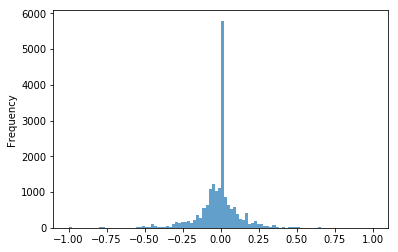

In [2]:
# Summary Distribution before preprocessing
driving_log = pd.read_csv("data/driving_log.csv")
driving_log.columns = ['center_image','left_image','right_image','steering_angle','throttle','break','speed']
driving_log.steering_angle.plot.hist(alpha=0.7,bins=100)
_summary = {'mean':driving_log.steering_angle.mean(), 
'median':driving_log.steering_angle.median(),
'max':driving_log.steering_angle.max(),
'min':driving_log.steering_angle.min(),
'std': driving_log.steering_angle.std()}
_summary

## Ground Truth Smoothing

In [3]:
# Output smoothing - smooth the ground truth steering angle by applying a rolling mean
# First compute the time difference between window start and end to make sure the frames
# belong to the same sequence
frame_lookback = 10 
def compute_timestamp(df):
    conv = "%Y%m%d%H%M%S%f"
    r = r'(.*)(center_)(.*)(.jpg)'
    _res = df.center_image.str.match(r)
    df['record_time'] = [datetime.strptime(r[2].replace("_",""),conv) for r in _res]
    df['record_diff'] = df['record_time'].diff(frame_lookback) / np.timedelta64(1, 's')
    return df

In [4]:
# The  module retrieves the time the image is captured and the delta between consecutive images 
import functools
driving_log = compute_timestamp(driving_log)
_median_lookback = driving_log.record_diff.median()
print("Median time lapse between 10 frames: {}".format(_median_lookback))

def apply_smoothing(row, lookback):
    if row['record_diff'] > lookback:
        # Do not smooth otherwise
        return row['steering_angle']
    else:
        return row['smooth_steering_angle']
# Add some leeway to include initial dataset in smoothing
smoothing_fn = functools.partial(apply_smoothing, lookback= _median_lookback + 1 )
driving_log['smooth_steering_angle'] = driving_log['steering_angle'].rolling(frame_lookback).mean()
driving_log['smooth_steering_angle'] = driving_log.apply(smoothing_fn,axis=1).fillna(0)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.


Median time lapse between 10 frames: 0.914


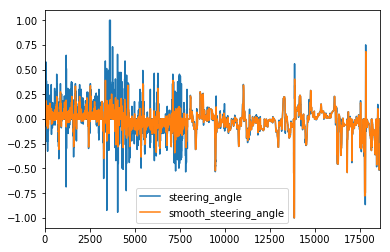

In [5]:
driving_log[['steering_angle','smooth_steering_angle']].plot()

In [6]:
# Removing straight angles now
keep_straight_p = 1
keep = lambda x: True if np.random.random() < keep_straight_p or x != 0 else False
driving_log['is_kept'] = driving_log.steering_angle.apply(keep)
print("Before filter: {}".format(driving_log.shape[0]))
filtered_driving_log = driving_log[driving_log['is_kept']]
print("After filter: {}".format(filtered_driving_log.shape[0]))

Before filter: 18589
After filter: 18589


{'max': 0.6822744799999978,
 'mean': -0.017034643285927159,
 'median': -0.00011792454000112715,
 'min': -1.0000000000000009,
 'std': 0.1221707963527643}

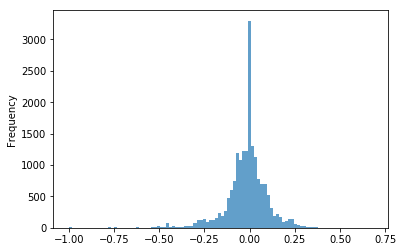

In [7]:
# Ground truth processing after smoothing & filtering
filtered_driving_log.smooth_steering_angle.plot.hist(alpha=0.7,bins=100)
_summary = {'mean':filtered_driving_log.steering_angle.mean(), 
'median':filtered_driving_log.smooth_steering_angle.median(),
'max':filtered_driving_log.smooth_steering_angle.max(),
'min':filtered_driving_log.smooth_steering_angle.min(),
'std': filtered_driving_log.smooth_steering_angle.std()}
_summary

In [8]:
# adjust the steering angle heuristicly
# filter instances of straight driving
# create a mapping from imagenames to angles
# Take the smoothed angle
f = lambda x: "".join(x.split("/")[-1])
correction = 0.25
center = pd.DataFrame({'image': filtered_driving_log['center_image'].apply(f), 'steering_angle': filtered_driving_log['smooth_steering_angle']})
left = pd.DataFrame({'image': filtered_driving_log['left_image'].apply(f), 'steering_angle': filtered_driving_log['smooth_steering_angle'] + correction })
right = pd.DataFrame({'image': filtered_driving_log['right_image'].apply(f), 'steering_angle': filtered_driving_log['smooth_steering_angle'] - correction})

steering_angles = pd.concat([center, left, right])
target_map = pd.Series(steering_angles.steering_angle.values,index=steering_angles.image).to_dict()
print("image data size: {}".format(len(target_map)))

_dir = "data/IMG/"

# Assert # images == # of annotated images
file_names = os.listdir(_dir)
assert len(target_map) == len(file_names)
# No NaNs in the target data
assert sum(np.isnan(np.fromiter(iter(target_map.values()), dtype=float))) == 0

image data size: 55767


In [9]:
from data_generator.image import ImageDataGenerator
input_shape, output_shape = (160, 320, 3) , (32, 128, 3)
batch_size = 128

## Visualizations

done


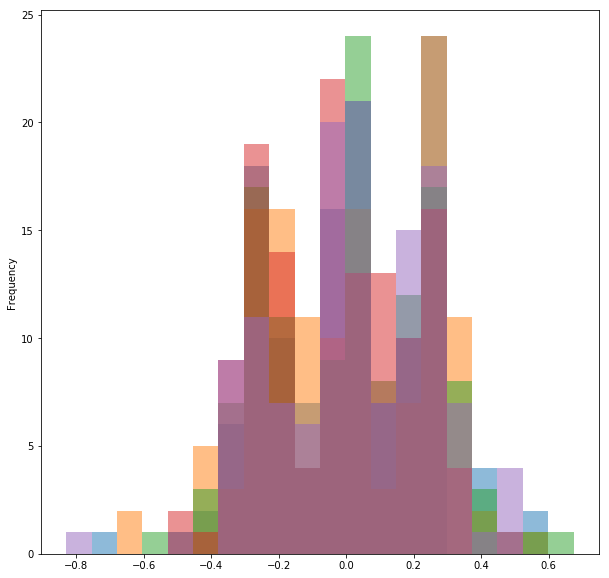

In [10]:
# investigate target distribution
gen = ImageDataGenerator(target_map = target_map, 
                         root_path = _dir, 
                         input_shape = input_shape, 
                         output_shape = output_shape, 
                         batch_size = batch_size)
# Generate some data
i = 0
X, y = [], []
while i < 5:
    i += 1
    _x, _y = next(gen)
    X.append(_x)
    y.append(_y)
print("done")

# Visualize the distribution of simulated training targets for couple of batches of training data
df = pd.DataFrame(y).T
f = plt.figure(figsize=(10, 10))
df.plot.hist(alpha=0.5, bins=20, legend=False, ax=f.gca())

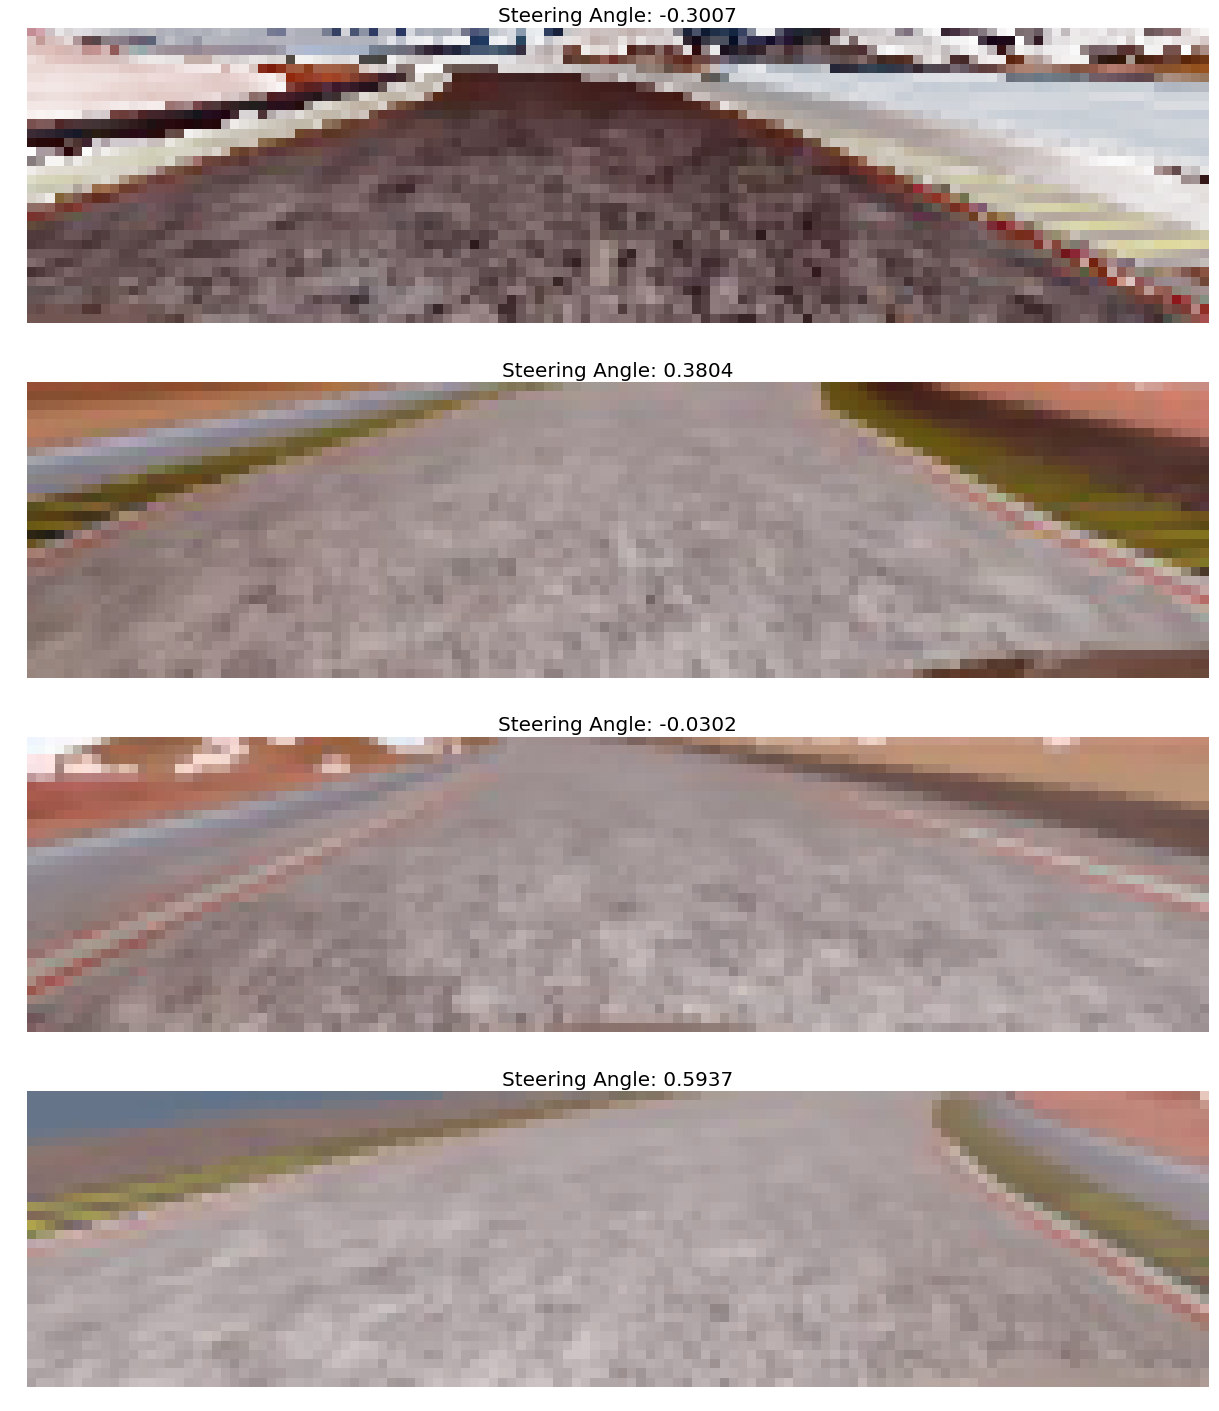

In [11]:
nb_images = 4
i = np.random.randint(1,128,nb_images)
#plt.imshow(X[0][5])
plt.figure(figsize=(75,25))
for ix, _i in enumerate(i):
    plt.subplot(nb_images,1,ix+1)
    plt.imshow(X[0][_i,...]) 
    plt.axis('off')
    plt.title("Steering Angle: " + str(np.round(y[0][_i],4)),fontsize=20);

# Training

In [12]:
# Set up the training and validation generator
train_gen = ImageDataGenerator(target_map = target_map, 
                         root_path = _dir, 
                         input_shape = input_shape, 
                         output_shape = output_shape, 
                         batch_size = batch_size)

val_gen = ImageDataGenerator(target_map = target_map, 
                         root_path = _dir, 
                         input_shape = input_shape, 
                         output_shape = output_shape, 
                         batch_size = batch_size,
                         training = False)

In [ ]:
# Set up the model
from model.model import CNNModel
model = CNNModel(input_shape = output_shape, 
                 nb_fully_connected = 128, 
                 filter_sizes = [8,5,3], 
                 pool_size = (2,2), 
                 dropout_p = 0.5, 
                 l2_reg = 0.001 )
print("Model Summary:")
model.model.summary()

Using TensorFlow backend.


Building model...
Compiled the model...
Model Summary:
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 32, 128, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 128, 16)   3088        lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 64, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 64, 32)    12832       maxpooling2d_1[0][0]             
____________________________________

In [ ]:
# Call *fit_generator*
hist = model.train(train_gen,
                   batch_size = 100,
                   nb_epochs= 50,
                   val_gen = val_gen
                  )

Epoch 1/50
4992/5000 [============================>.] - ETA: 0s - loss: 0.3969  

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


5120/5000 [==============================] - 146s - loss: 0.3962 - val_loss: 0.3620
Epoch 2/50
5120/5000 [==============================] - 119s - loss: 0.3376 - val_loss: 0.3094

In [ ]:
#save the model
model.save("model.json", "model.h5" )